In [48]:
import pandas as pd
import altair as alt
import numpy as np
import math
from altair import datum

In [49]:
# enable correct rendering
alt.renderers.enable('default')

RendererRegistry.enable('default')

In [50]:
# uses intermediate json files to speed things up
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [51]:
sw = pd.read_csv('assets/StarWars.csv', encoding='latin1')

In [52]:
# Some format is needed for the survey dataframe, I provide the formatted dataset in a dataframe 
sw = sw.rename(columns={'Have you seen any of the 6 films in the Star Wars franchise?':'seen_any_movie',
                        'Do you consider yourself to be a fan of the Star Wars film franchise?': 'fan',
                        'Which of the following Star Wars films have you seen? Please select all that apply.' : 'seen_EI',
                        'Unnamed: 4' : 'seen_EII',
                        'Unnamed: 5' : 'seen_EIII',
                        'Unnamed: 6' : 'seen_EIV',
                        'Unnamed: 7' : 'seen_EV',
                        'Unnamed: 8' : 'seen_EVI',
                        'Please rank the Star Wars films in order of preference with 1 being your favorite film in the franchise and 6 being your least favorite film.' : 'rank_EI',
                        'Unnamed: 10' : 'rank_EII',
                        'Unnamed: 11' : 'rank_EIII',
                        'Unnamed: 12' : 'rank_EIV',
                        'Unnamed: 13' : 'rank_EV',
                        'Unnamed: 14' : 'rank_EVI',
                        'Please state whether you view the following characters favorably, unfavorably, or are unfamiliar with him/her.' : 'Han Solo',
                        'Unnamed: 16' : 'Luke Skywalker',
                        'Unnamed: 17' : 'Princess Leia Organa',
                        'Unnamed: 18' : 'Anakin Skywalker',
                        'Unnamed: 19' : 'Obi Wan Kenobi',
                        'Unnamed: 20' : 'Emperor Palpatine',
                        'Unnamed: 21' : 'Darth Vader',
                        'Unnamed: 22' : 'Lando Calrissian',
                        'Unnamed: 23' : 'Boba Fett',
                        'Unnamed: 24' : 'C-3P0',
                        'Unnamed: 25' : 'R2 D2',
                        'Unnamed: 26' : 'Jar Jar Binks',
                        'Unnamed: 27' : 'Padme Amidala',
                        'Unnamed: 28' : 'Yoda',
                       })
sw = sw.drop([0])

In [53]:
# take a peak to look at the data
sw.sample(5)

,RespondentID,seen_any_movie,fan,seen_EI,seen_EII,seen_EIII,seen_EIV,seen_EV,seen_EVI,rank_EI,...,Yoda,Which character shot first?,Are you familiar with the Expanded Universe?,Do you consider yourself to be a fan of the Expanded Universe?æ,Do you consider yourself to be a fan of the Star Trek franchise?,Gender,Age,Household Income,Education,Location (Census Region)
204,3.290994e+09,Yes,No,Star Wars: Episode I The Phantom Menace,Star Wars: Episode II Attack of the Clones,Star Wars: Episode III Revenge of the Sith,Star Wars: Episode IV A New Hope,NaN,Star Wars: Episode VI Return of the Jedi,5,...,Somewhat favorably,Greedo,Yes,No,No,Male,18-29,"$0 - $24,999",High school degree,Middle Atlantic
886,3.289463e+09,Yes,Yes,Star Wars: Episode I The Phantom Menace,Star Wars: Episode II Attack of the Clones,Star Wars: Episode III Revenge of the Sith,Star Wars: Episode IV A New Hope,Star Wars: Episode V The Empire Strikes Back,Star Wars: Episode VI Return of the Jedi,1,...,Very favorably,Han,Yes,No,Yes,Male,45-60,"$25,000 - $49,999",Some college or Associate degree,East North Central
537,3.290310e+09,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,Male,> 60,"$0 - $24,999",High school degree,West South Central
571,3.290203e+09,Yes,Yes,Star Wars: Episode I The Phantom Menace,Star Wars: Episode II Attack of the Clones,Star Wars: Episode III Revenge of the Sith,Star Wars: Episode IV A New Hope,Star Wars: Episode V The Empire Strikes Back,Star Wars: Episode VI Return of the Jedi,2,...,Somewhat favorably,I don't understand this question,No,NaN,Yes,Male,45-60,"$150,000+",Bachelor degree,New England
901,3.289418e+09,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
# Sample visualization

# I'm going to fix the labels a bit so will create a mapping to the full names
episodes = ['EI', 'EII', 'EIII', 'EIV', 'EV', 'EVI']
names = {
    'EI' : 'The Phantom Meanance', 'EII' : 'Attack of the clones', 'EIII' : 'Revenge of the Sith', 
    'EIV': 'A New Hope', 'EV': 'The Empire Strikes Back', 'EVI' : 'The Return of the Jedi'
}

# I am also going to use this order to sort, so names_l will now have our sort order
names_l = [names[ep] for ep in episodes]

print("sort order: ",names_l)

sort order:  ['The Phantom Meanance', 'Attack of the clones', 'Revenge of the Sith', 'A New Hope', 'The Empire Strikes Back', 'The Return of the Jedi']


In [55]:
# let's do some data pre-processing... sw (star wars) has everything

# I want to only use those people who have seen at least one movie, let's get the people, toss NAs
# and get the total count

# find people who have at least on of the columns (seen_*) not NaN
seen_at_least_one = sw.dropna(subset=['seen_' + ep for ep in episodes],how='all')
total = len(seen_at_least_one)

print("total who have seen at least one: ", total)

total who have seen at least one:  835


In [56]:
# for each movie, I'm going to calculate the percents and generate a new data frame
percs = []

# loop over each column and calculate the number of people who have seen the movie
# specifically, filter out the people who are *NaN* for a specific episode (e.g., ep_EII), count them
# and divide by the percent
for seen_ep in ['seen_' + ep for ep in episodes]:
    perc = len(seen_at_least_one[~ pd.isna(seen_at_least_one[seen_ep])]) / total
    percs.append(perc)
    
# at this point percs is holding our percentages

# now I'm going use a trick to make tuples--pairing names with percents--using "zip" and then make a dataframe
tuples = list(zip([names[ep] for ep in episodes],percs))
seen_per_df = pd.DataFrame(tuples, columns = ['Name', 'Percentage'])
seen_per_df

,Name,Percentage
0,The Phantom Meanance,0.805988
1,Attack of the clones,0.683832
2,Revenge of the Sith,0.658683
3,A New Hope,0.726946
4,The Empire Strikes Back,0.907784
5,The Return of the Jedi,0.883832


In [57]:
# ok, time to make the chart... let's make a bar chart (use mark_bar)
bars = alt.Chart(seen_per_df).mark_bar(size=20).encode(
    # encode x as the percent, and hide the axis
    x=alt.X(
        'Percentage',
        axis=None),
    y=alt.Y(
        # encode y using the name, use the movie name to label the axis, sort using the names_l
        'Name:N',
         axis=alt.Axis(tickCount=5, title=''),
         # we give the sorting order to avoid alphabetical order
         sort=names_l
    )
)

# at this point I don't really have a great plot (it's missing the annotations, titles, etc.)
bars


alt.Chart(...)

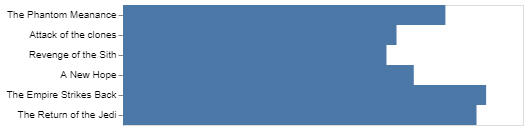

In [58]:
# I'm going to overlay the text with the percentages, so let's make another visualization
# that's just text labels

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    # I will use the percentage as the text
    text=alt.Text('Percentage:Q',format='.0%')
)

# finally, I'm going to combine the bars and the text and do some styling
seen_movies = (text + bars).configure_mark(
    # we don't love the blue
    color='#008fd5'
).configure_view(
    # I don't want a stroke around the bars
    strokeWidth=0
).configure_scale(
    # add some padding
    bandPaddingInner=0.2
).properties(
    # set the dimensions of the visualization
    width=500,
    height=180
).properties(
    # add a title
    title="Which 'Star Wars' Movies Have you Seen?"
)

seen_movies

alt.LayerChart(...)

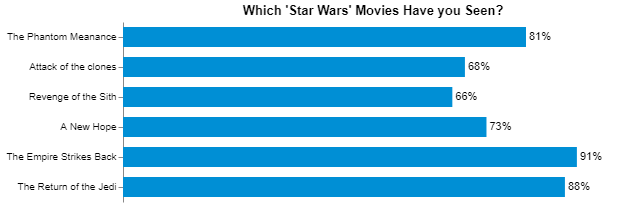

In [59]:
# Sample visualization

# I'm going to fix the labels a bit so will create a mapping to the full names
episodes = ['EI', 'EII', 'EIII', 'EIV', 'EV', 'EVI']
names = {
    'EI' : 'The Phantom Meanance', 'EII' : 'Attack of the clones', 'EIII' : 'Revenge of the Sith', 
    'EIV': 'A New Hope', 'EV': 'The Empire Strikes Back', 'EVI' : 'The Return of the Jedi'
}

# I'm also going to use this order to sort, so names_l will now have our sort order
names_l = [names[ep] for ep in episodes]

print("sort order: ",names_l)

seen_every = seen_at_least_one.dropna(subset=['seen_EI','seen_EII','seen_EIII','seen_EIV','seen_EV','seen_EVI'])


# let's do some data pre-processing... sw (star wars) has everything

# I want to only use those people who have seen at least one movie, let's get the people, toss NAs
# and get the total count

# find people who have at least on of the columns (seen_*) not NaN
seen_at_least_one = sw.dropna(subset=['seen_' + ep for ep in episodes],how='all')
total = len(seen_every)

seen_every = seen_at_least_one.dropna(subset=['seen_EI','seen_EII','seen_EIII','seen_EIV','seen_EV','seen_EVI'])

print("total who have seen at least one: ", total)

# for each movie, I'm going to calculate the percents and generate a new data frame
percs = []

for rank_ep in ['rank_' + ep for ep in episodes]:
    #my_value_count = seen_every[rank_ep].value_counts()
    perc_seen_every = (seen_every[rank_ep].value_counts()['1'])/ total
    percs.append(perc_seen_every)
    
# at this point percs is holding my percentages

# now I'm going use a trick to make tuples--pairing names with percents--using "zip" and then make a dataframe
tuples = list(zip([names[ep] for ep in episodes],percs))
seen_per_df = pd.DataFrame(tuples, columns = ['Name', 'Percentage'])
seen_per_df

tuples_every = list(zip([names[ep] for ep in episodes],percs))
seen_every_df = pd.DataFrame(tuples_every, columns = ['Name', 'Percentage'])
seen_every_df

# ok, time to make the chart... let's make a bar chart (use mark_bar)
bars = alt.Chart(seen_per_df).mark_bar(size=20).encode(
    # encode x as the percent, and hide the axis
    x=alt.X(
        'Percentage',
        axis=None),
    y=alt.Y(
        # encode y using the name, use the movie name to label the axis, sort using the names_l
        'Name:N',
         axis=alt.Axis(tickCount=5, title=''),
         # we give the sorting order to avoid alphabetical order
         sort=names_l
    )
)

# at this point I don't really have a great plot (it's missing the annotations, titles, etc.)
bars

# I am going to overlay the text with the percentages, so let's make another visualization
# that's just text labels

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    # we'll use the percentage as the text
    text=alt.Text('Percentage:Q',format='.0%')
)

# finally, I'm going to combine the bars and the text and do some styling
seen_movies = (text + bars).configure_mark(
    # we don't love the blue
    color='#008fd5'
).configure_view(
    # I don't want a stroke around the bars
    strokeWidth=0
).configure_scale(
    # add some padding
    bandPaddingInner=0.2
).properties(
    # set the dimensions of the visualization
    width=500,
    height=180
).properties(
    # add a title
    title={
    "text":["What's the best 'Star Wars' Movie?"],
    "subtitle":["Of 471 respondents who have seen all six films"]}
).configure_title(
    # customize title and sub-title
    fontSize=30, align='left',anchor ='start', fontWeight='bold', subtitleFontWeight='lighter'
)

seen_movies

sort order:  ['The Phantom Meanance', 'Attack of the clones', 'Revenge of the Sith', 'A New Hope', 'The Empire Strikes Back', 'The Return of the Jedi']
total who have seen at least one:  471


alt.LayerChart(...)

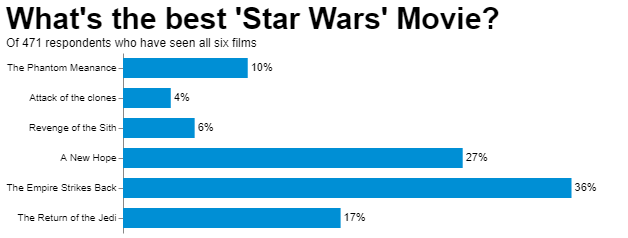

In [60]:
# fix the labels a bit so will create a mapping to the full names
episodes = ['EI', 'EII', 'EIII', 'EIV', 'EV', 'EVI']
names = {
    'EI' : 'The Phantom Meanance', 'EII' : 'Attack of the clones', 'EIII' : 'Revenge of the Sith', 
    'EIV': 'A New Hope', 'EV': 'The Empire Strikes Back', 'EVI' : 'The Return of the Jedi'
}

# going to use this order to sort, so names_l will now have our sort order
names_l = [names[ep] for ep in episodes]


seen_every = seen_at_least_one.dropna(subset=['seen_EI','seen_EII','seen_EIII','seen_EIV','seen_EV','seen_EVI'])


# let's do some data pre-processing... sw (star wars) has everything

# I want to only use those people who have seen at least one movie, let's get the people, toss NAs
# and get the total count

# find people who have at least on of the columns (seen_*) not NaN
seen_at_least_one = sw.dropna(subset=['seen_' + ep for ep in episodes],how='all')
total = len(seen_every)

seen_every = seen_at_least_one.dropna(subset=['seen_EI','seen_EII','seen_EIII','seen_EIV','seen_EV','seen_EVI'])


total_rank = len(seen_every)

# calculating the percents and generating a new data frame
percs_seen_top3 = []

# looping over each column and calculating the number of people who have seen the movie
# specifically, filter out the people who are *NaN* for a specific episode (e.g., ep_EII), count them
# and divide by the percent

for rank_ep in ['rank_' + ep for ep in episodes]:
    #my_value_count = seen_every[rank_ep].value_counts()
    perc_seen_top3 = (seen_every[rank_ep].value_counts()['1'] + seen_every[rank_ep].value_counts()['2'])/ total_rank 
    percs_seen_top3.append(perc_seen_top3)

# creating tuples--pairing names with percents--using "zip" and then making a dataframe
tuples_top = list(zip([names[ep] for ep in episodes],percs_seen_top3))
seen_per_df_top = pd.DataFrame(tuples_top, columns = ['Name', 'Percentage'])

bars_top = alt.Chart(seen_per_df_top).mark_bar(size=20,color="#2ca02c").encode(
    # encode x as the percent, and hide the axis
    x=alt.X(
        'Percentage',
        axis=None),
    y=alt.Y(
        # encode y using the name, use the movie name to label the axis, sort using the names_l
        'Name:N',
#        axis=None),
         axis=alt.Axis(tickCount=5, title=''),
         # we give the sorting order to avoid alphabetical order
         sort=names_l
    
    )
)


text_top = bars_top.mark_text(
    align='left',
    baseline='middle',
    color="#2ca02c",
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    # we'll use the percentage as the text
    text=alt.Text('Percentage:Q',format='.0%')
)


seen_movies_top = (text_top + bars_top).configure_mark(
#    color='#008fd5'
).configure_view(
    # we don't want a stroke around the bars
    strokeWidth=0
).configure_scale(
    # add some padding
    bandPaddingInner=0.2
).properties(
    # set the dimensions of the visualization
    width=500,
    height=180
)

percs_seen_middle3 = []

for rank_ep in ['rank_' + ep for ep in episodes]:
    perc_seen_middle3 = (seen_every[rank_ep].value_counts()['3'] + seen_every[rank_ep].value_counts()['4'])/ total_rank 
    percs_seen_middle3.append(perc_seen_middle3)
    
tuples_middle = list(zip([names[ep] for ep in episodes],percs_seen_middle3))
seen_per_df_middle = pd.DataFrame(tuples_middle, columns = ['Name', 'Percentage'])

# ok, time to make the chart... let's make a bar chart (use mark_bar)
bars_middle = alt.Chart(seen_per_df_middle).mark_bar(size=20,color="#008fd5").encode(
    # encode x as the percent, and hide the axis
    x=alt.X(
        'Percentage',
        axis=None),
    y=alt.Y('Name:N',axis=None,sort=names_l
    ))

text_middle = bars_middle.mark_text(
    align='left',
    baseline='middle',
    color="#008fd5",
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    # we'll use the percentage as the text
    text=alt.Text('Percentage:Q',format='.0%')
)

seen_movies_middle = (text_middle + bars_middle).configure_mark(
    # I don't love the blue
#    color='#69a14f'
).configure_view(
    # I don't want a stroke around the bars
    strokeWidth=0
).configure_scale(
    # add some padding
    bandPaddingInner=0.2
).properties(
    # set the dimensions of the visualization
    width=500,
    height=180
)


percs_seen_bottom3 = []

for rank_ep in ['rank_' + ep for ep in episodes]:
    perc_seen_bottom3 = (seen_every[rank_ep].value_counts()['5'] + seen_every[rank_ep].value_counts()['6'])/ total_rank 
    percs_seen_bottom3.append(perc_seen_bottom3)  

tuples_bottom = list(zip([names[ep] for ep in episodes],percs_seen_bottom3))
seen_per_df_bottom = pd.DataFrame(tuples_bottom, columns = ['Name', 'Percentage'])

# ok, time to make the chart... let's make a bar chart (use mark_bar)
bars_bottom = alt.Chart(seen_per_df_bottom).mark_bar(size=20,color="#D62728").encode(
    # encode x as the percent, and hide the axis
    x=alt.X(
        'Percentage',
        axis=None),
    y=alt.Y('Name:N',axis=None,sort=names_l
    ))

text_bottom = bars_bottom.mark_text(
    align='left',
    baseline='middle',
    color="#D62728",
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    # I'll use the percentage as the text
    text=alt.Text('Percentage:Q',format='.0%')
)


seen_movies_bottom = (text_bottom + bars_bottom).configure_mark(
    # I don't love the blue
    color='#fd3a4a'
).configure_view(
    # I don't want a stroke around the bars
    strokeWidth=0
).configure_scale(
    # add some padding
    bandPaddingInner=0.2
).properties(
    # set the dimensions of the visualization
    width=500,
    height=180
)



chart_top = (text_top + bars_top).properties(
    width=80,
    height=180,
    title=alt.TitleParams("Top third", dx=160,fontSize=15)
)

chart_middle = (text_middle + bars_middle).properties(
    width=80,
    height=180,
    title=alt.TitleParams("Middle third", fontSize=15)
)

chart_bottom = (text_bottom + bars_bottom).properties(
    width=80,
    height=180,
    title=alt.TitleParams("Bottom third", fontSize=15)

)

merge = alt.hconcat(chart_top, chart_middle, chart_bottom).configure_scale(
    bandPaddingInner=0.2
).configure_view(
    strokeWidth=0
).properties(
    title={"text":["How People Rate the 'Star Wars' Movies"],
    "subtitle":["How often each film was rated in the top, middle and bottom third",
                '(by 471 respondents who have seen all six films)']}
).configure_title(
    fontSize=24, align='left', fontWeight='bold', anchor="start",
).configure_axis(
    labelFontSize=14)

alt.themes.enable('fivethirtyeight')

merge


alt.HConcatChart(...)

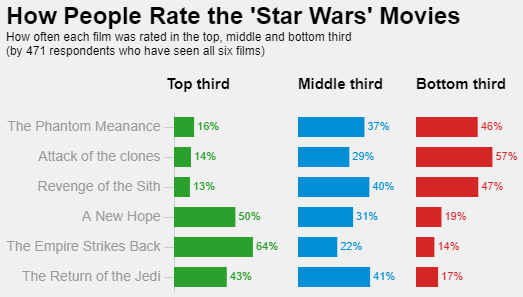

In [61]:
# I'm going to fix the labels a bit so will create a mapping to the full names
characters= ['C_1', 'C_2','C_3','C_4','C_5','C_6','C_7','C_8','C_9','C_10','C_11','C_12','C_13','C_14']
characters_l = {'C_1':'Luke Skywalker',
              'C_2':'Han Solo',
              'C_3':'Princess Leia Organa',
              'C_4':'Obi Wan Kenobi',
              'C_5':'Yoda',
              'C_6':'R2 D2',
              'C_7':'C-3P0',
              'C_8':'Anakin Skywalker',
              'C_9':'Darth Vader',
              'C_10':'Lando Calrissian',
              'C_11':'Padme Amidala',
              'C_12':'Boba Fett',
              'C_13':'Emperor Palpatine',
              'C_14':'Jar Jar Binks'}         
   
print("sort order: ",characters_l)

sort order:  {'C_1': 'Luke Skywalker', 'C_2': 'Han Solo', 'C_3': 'Princess Leia Organa', 'C_4': 'Obi Wan Kenobi', 'C_5': 'Yoda', 'C_6': 'R2 D2', 'C_7': 'C-3P0', 'C_8': 'Anakin Skywalker', 'C_9': 'Darth Vader', 'C_10': 'Lando Calrissian', 'C_11': 'Padme Amidala', 'C_12': 'Boba Fett', 'C_13': 'Emperor Palpatine', 'C_14': 'Jar Jar Binks'}


In [62]:

names_char= [characters_l[char] for char in characters_l]
char_df=sw.dropna(subset=[characters_l[char] for char in characters_l],how='all')
total_char = len(char_df)

percent_fav = []

for actor_ep in [characters_l[char] for char in characters_l]:
    perc_fav = (char_df[actor_ep].value_counts()['Very favorably'] + char_df[actor_ep].value_counts()['Somewhat favorably']) / total_char
    percent_fav.append(perc_fav)
    
tuples_fav = list(zip([characters_l[char] for char in characters_l],percent_fav))
char_fav_df = pd.DataFrame(tuples_fav, columns = ['Name', 'Percentage'])
char_fav_df

percent_neutral = []

for actor_ep in [characters_l[char] for char in characters_l]:
    perc_neutral = (char_df[actor_ep].value_counts()['Neither favorably nor unfavorably (neutral)']) / total_char
    percent_neutral.append(perc_neutral)
    
tuples_neutral = list(zip([characters_l[char] for char in characters_l],percent_neutral))
char_neutral_df = pd.DataFrame(tuples_neutral, columns = ['Name', 'Percentage'])
char_neutral_df


percent_unfav = []

for actor_ep in [characters_l[char] for char in characters_l]:
    perc_unfav = (char_df[actor_ep].value_counts()['Very unfavorably'] + char_df[actor_ep].value_counts()['Somewhat unfavorably']) / total_char 
    percent_unfav.append(perc_unfav)
    
tuples_unfav = list(zip([characters_l[char] for char in characters_l],percent_unfav))
char_unfav_df = pd.DataFrame(tuples_unfav, columns = ['Name', 'Percentage'])
char_unfav_df


percent_unfamiliar = []

for actor_ep in [characters_l[char] for char in characters_l]:
    perc_unfamiliar = (char_df[actor_ep].value_counts()['Unfamiliar (N/A)']) / total_char 
    percent_unfamiliar.append(perc_unfamiliar)
    
tuples_unfamiliar = list(zip([characters_l[char] for char in characters_l],percent_unfamiliar))
char_unfamiliar_df = pd.DataFrame(tuples_unfamiliar, columns = ['Name', 'Percentage'])
char_unfamiliar_df

,Name,Percentage
0,Luke Skywalker,0.007194
1,Han Solo,0.017986
2,Princess Leia Organa,0.009592
3,Obi Wan Kenobi,0.020384
4,Yoda,0.011990
5,R2 D2,0.011990
6,C-3P0,0.017986
7,Anakin Skywalker,0.062350
8,Darth Vader,0.011990
9,Lando Calrissian,0.177458


In [63]:
bars_fav = alt.Chart(char_fav_df).mark_bar(color= '#2ca02c',size=20).encode(
    # encode x as the percent, and hide the axis
    x=alt.X(
        'Percentage',
        axis=None),
    
    y=alt.Y(
        # encode y using the name, use the movie name to label the axis, sort using the names_l
        'Name:N',
         # I give the sorting order to avoid alphabetical order
         sort=names_l))
bars_fav
text_fav = bars_fav.mark_text(
    align='left',
    baseline='middle',
    color='#2ca02c',
    dx= 5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    # I'll use the percentage as the text
    text=alt.Text('Percentage:Q',format='.0%')
)
fav_chart = (text_fav + bars_fav).properties(
    # set the dimensions of the visualization
    width=80,
    height=320,
    title=("Favorable"))


In [64]:

bars_neutral = alt.Chart(char_neutral_df).mark_bar(color= '#008fd5',size=20).encode(
    # encode x as the percent, and hide the axis
    x=alt.X(
        'Percentage',
        axis=None),
    
    y=alt.Y(
        # encode y using the name, use the movie name to label the axis, sort using the names_l
        'Name:N',
         axis=None,
         # we give the sorting order to avoid alphabetical order
         sort=names_l))
bars_neutral

text_neutral = bars_neutral.mark_text(
    align='left',
    baseline='middle',
    color='#008fd5',
    dx= 5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    # I'll use the percentage as the text
    text=alt.Text('Percentage:Q',format='.0%')
)
neutral_chart = (text_neutral + bars_neutral).properties(
    # set the dimensions of the visualization
    width=80,
    height=320,
    title=("Neutral"))


In [65]:


bars_unfav = alt.Chart(char_unfav_df).mark_bar(color= '#D62728',size=20).encode(
    # encode x as the percent, and hide the axis
    x=alt.X(
        'Percentage',
        axis=None),
    
    y=alt.Y(
        # encode y using the name, use the movie name to label the axis, sort using the names_l
        'Name:N',
         axis=None,
         # we give the sorting order to avoid alphabetical order
         sort=names_l))
bars_unfav
text_unfav = bars_unfav.mark_text(
    align='left',
    baseline='middle',
    color='#D62728',
    dx= 5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    # I'll use the percentage as the text
    text=alt.Text('Percentage:Q',format='.0%')
)
unfav_chart = (text_unfav + bars_unfav).properties(
    # set the dimensions of the visualization
    width=80,
    height=320,
    title=("Unfavorable"))


In [66]:

bars_unfamiliar = alt.Chart(char_unfamiliar_df).mark_bar(color= '#7f7f7f',size=20).encode(
    # encode x as the percent, and hide the axis
    x=alt.X(
        'Percentage',
        axis=None),
    
    y=alt.Y(
        # encode y using the name, use the movie name to label the axis, sort using the names_l
        'Name:N',
         axis=None,
         # I give the sorting order to avoid alphabetical order
         sort=names_l))
bars_unfamiliar
text_unfamiliar = bars_unfamiliar.mark_text(
    align='left',
    baseline='middle',
    color='#7f7f7f',
    dx= 5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    # I'll use the percentage as the text
    text=alt.Text('Percentage:Q',format='.0%')
)
unfamiliar_chart = (text_unfamiliar + bars_unfamiliar).properties(
    # set the dimensions of the visualization
    width=80,
    height=320,
    title=("Unfamiliar"))


In [67]:
fav_chart1 = (text_fav + bars_fav).properties(
    width=80,
    height=180,
    title=alt.TitleParams("Favorable", dx=160,fontSize=15)
)

neutral_chart1 = (text_neutral + bars_neutral).properties(
    width=80,
    height=180,
    title=alt.TitleParams("Neutral", fontSize=15)
)

unfav_chart1 = (text_unfav + bars_unfav).properties(
    width=80,
    height=180,
    title=alt.TitleParams("Unfavorable", fontSize=15)

)

unfamiliar_chart1 = (text_unfamiliar + bars_unfamiliar).properties(
    width=80,
    height=180,
    title=alt.TitleParams("Unfamiliar", fontSize=15)

)


In [68]:
merged = alt.hconcat(fav_chart1, neutral_chart1, unfav_chart1, unfamiliar_chart1).configure_scale(
    bandPaddingInner=0.2
).configure_view(
    strokeWidth=0
).properties(
    title={"text":["'Star Wars' Characters Favorability Ratings"],
    "subtitle":["By 826 respondents"]}
).configure_title(
    fontSize=24, align='left', fontWeight='bold', anchor="start",
).configure_axis(
    labelFontSize=14)

alt.themes.enable('fivethirtyeight')

merged

# note that we are NOT formatting this in the Five Thirty Eight Style yet... we'll leave that to you to figure out

alt.HConcatChart(...)

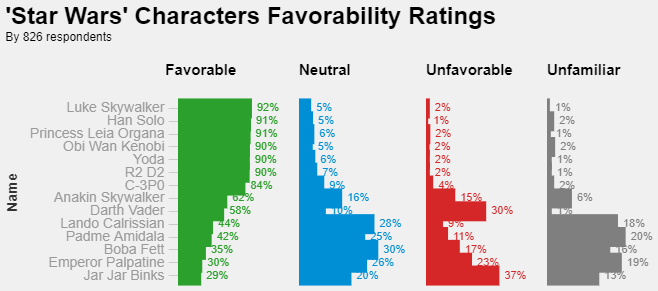

In [69]:
new_df = sw.dropna(subset=['Which character shot first?'],how='all')
length =  len(new_df)
new_df  =  sw['Which character shot first?'].groupby(sw['Which character shot first?']).agg(['count']).reset_index()
new_df  =  new_df.set_index('Which character shot first?')
new_df['Percentage']  =  new_df['count'].apply(lambda x: x/length)
new_df  =  new_df.drop(['count'],axis  = 1)
new_df  =  new_df.reset_index()

bars  =  alt.Chart(new_df).mark_bar(size = 20).encode(
    x = alt.X(
        'Percentage',
        axis = None),
    y = alt.Y(
        'Which character shot first?',
         axis = alt.Axis(tickCount = 5, title=''),
         #sort = names_l
    )
)

text  =  bars.mark_text(
    align='left',
    baseline='middle',
    dx = 3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text = alt.Text('Percentage:Q',format='.0%')
)

shot_first  =  (text + bars).configure_mark(
    color='#008fd5'
).configure_view(
    strokeWidth = 0
).configure_scale(
    bandPaddingInner = 0.2
).properties(
    width = 500,
    height = 180
).properties(
    title={"text":["Who Shot First?"],
    "subtitle":['According to 834 Respondents']}
)

shot_first

alt.LayerChart(...)

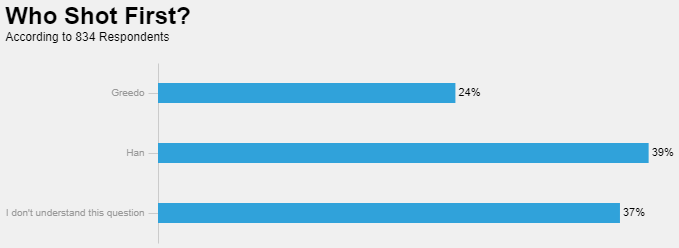

In [70]:
new_df = sw.dropna(subset=['Do you consider yourself to be a fan of the Star Trek franchise?'],how='all')
length =  len(new_df)
new_df  =  sw['Do you consider yourself to be a fan of the Star Trek franchise?'].groupby(sw['Do you consider yourself to be a fan of the Star Trek franchise?']).agg(['count']).reset_index()
new_df  =  new_df.set_index('Do you consider yourself to be a fan of the Star Trek franchise?')
new_df['Percentage']  =  new_df['count'].apply(lambda x: x/length)
new_df  =  new_df.drop(['count'],axis  = 1)
new_df  =  new_df.reset_index()

bars  =  alt.Chart(new_df).mark_bar(size = 20).encode(
    x = alt.X(
        'Percentage',
        axis = None),
    y = alt.Y(
        'Do you consider yourself to be a fan of the Star Trek franchise?',
         axis = alt.Axis(tickCount = 5, title='')
    )
)

text  =  bars.mark_text(
    align='left',
    baseline='middle',
    dx = 3  
).encode(
    text = alt.Text('Percentage:Q',format='.0%')
)

shot_first  =  (text + bars).configure_mark(
    color='#008fd5'
).configure_view(
    strokeWidth = 0
).configure_scale(
    bandPaddingInner = 0.2
).properties(
    width = 500,
    height = 180
).properties(
    title={"text":["Do you consider yourself to be a fan of the Star Trek franchise?"],
    "subtitle":['According to 834 Respondents']}
)

shot_first

alt.LayerChart(...)

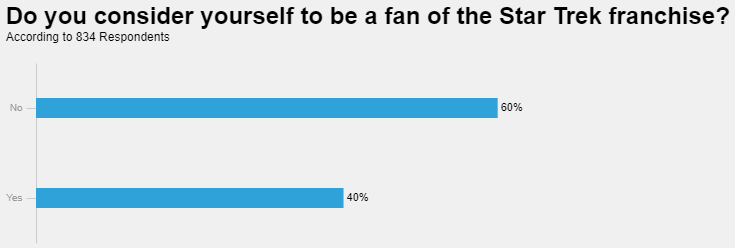